# Flower Recognition CNN Keras

## CONTENTS ::

[ **1 ) Importing Various Modules**](#content1)

[ **2 ) Preparing the Data**](#content2)

[ **3 ) Modelling**](#content3)

[ **4 ) Evaluating the Model Performance**](#content4)

[ **5 ) Visualizing Predictons on the Validation Set**](#content5)

<a id="content1"></a>
## 1 ) Importing Various Modules.

In [9]:
# Ignore  the warnings
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

# data visualisation and manipulation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
 
#configure
# sets matplotlib to inline and displays graphs below the corressponding cell.
%matplotlib inline  
style.use('fivethirtyeight')
sns.set(style='whitegrid',color_codes=True)

#model selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix,roc_curve,roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder

#preprocess.
from keras.preprocessing.image import ImageDataGenerator

#dl libraraies
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop
from keras.utils import to_categorical

# specifically for cnn
from keras.layers import Dropout, Flatten, Activation
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
 
import tensorflow as tf
import random as rn

# specifically for manipulating zipped images and getting numpy arrays of pixel values of images.
import cv2                  
import numpy as np  
from tqdm import tqdm
import os                   
from random import shuffle  
from zipfile import ZipFile
from PIL import Image



In [11]:
print("Num GPUs Available: ", len(tf.test.gpu_device_name()))

Num GPUs Available:  13


<a id="content2"></a>
## 2 ) Preparing the Data

## 2.1) Making the functions to get the training and validation set from the Images

In [90]:
X=[]
Z=[]
IMG_SIZE=128

DATA_DIR='../dataset/inputs_resized/flowers'
input_folder=DATA_DIR

def make_train_data(flower_type, DIR):
    for img in tqdm(os.listdir(DIR)):
        label=assign_label(img, flower_type)
        path = os.path.join(DIR,img)
        img = cv2.imread(path, cv2.IMREAD_COLOR)
        RGB_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        RGB_img = cv2.resize(RGB_img, (IMG_SIZE, IMG_SIZE))
        
        X.append(np.array(RGB_img))
        Z.append(str(label))

def assign_label(img, flower_type):
    return flower_type

# loop through each category folder
for category in os.listdir(input_folder):
    category_path = os.path.join(input_folder, category)
    if os.path.isdir(category_path):
        make_train_data(category, category_path)
        print(len(X))   

# Label Encoding the Y array (i.e. Daisy->0, Rose->1 etc...) & then One Hot Encoding
le=LabelEncoder()
Y=le.fit_transform(Z)
Y=to_categorical(Y,5)
X=np.array(X)
X=X/255

100%|██████████████████████████████████████████████████████████████████████████████| 764/764 [00:00<00:00, 3526.20it/s]


764


100%|██████████████████████████████████████████████████████████████████████████████| 784/784 [00:00<00:00, 3529.89it/s]


1548


100%|██████████████████████████████████████████████████████████████████████████████| 984/984 [00:00<00:00, 3246.85it/s]


2532


100%|████████████████████████████████████████████████████████████████████████████| 1052/1052 [00:00<00:00, 3578.48it/s]


3584


100%|██████████████████████████████████████████████████████████████████████████████| 733/733 [00:00<00:00, 3192.66it/s]


4317


## 2.2 ) Visualizing some Random Images

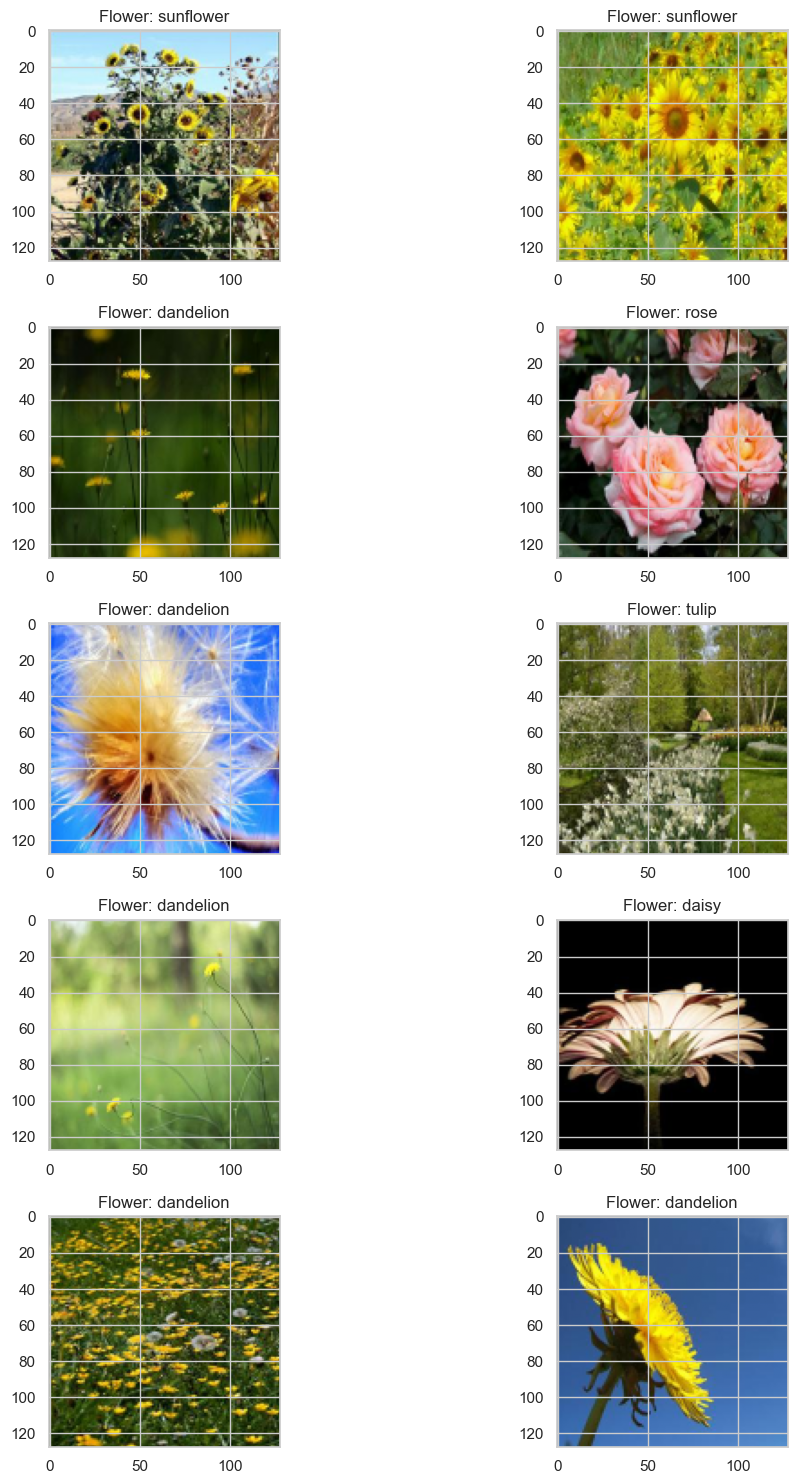

In [14]:
fig,ax=plt.subplots(5,2)
fig.set_size_inches(13,15)
for i in range(5):
    for j in range (2):
        l=rn.randint(0, len(Z))
        ax[i,j].imshow(X[l])
        ax[i,j].set_title('Flower: '+Z[l])
        
plt.tight_layout()
        

## 2.4 ) Splitting into Training and Validation Sets and Setting Random Seeds

In [15]:
np.random.seed(42)
rn.seed(42)
tf.random.set_seed(42)
x_train,x_test, y_train,y_test=train_test_split(X,Y,test_size=0.25,random_state=42)

<a id="content3"></a>
## 3 ) Modelling

## 3.1 ) Building the ConvNet Model

In [106]:
# Some outdated example
# # modelling starts using a CNN.

# model = Sequential()
# model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',activation ='relu', input_shape = (IMG_SIZE, IMG_SIZE, 3)))
# model.add(MaxPooling2D(pool_size=(2,2)))

# model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same',activation ='relu'))
# model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

# model.add(Conv2D(filters =96, kernel_size = (3,3),padding = 'Same',activation ='relu'))
# model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

# model.add(Conv2D(filters = 96, kernel_size = (3,3),padding = 'Same',activation ='relu'))
# model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

# model.add(Flatten())
# model.add(Dense(512))
# model.add(Activation('relu'))
# model.add(Dense(5, activation = "softmax"))

# Define the CNN model
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE,3)),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Conv2D(256, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(5, activation='softmax')
])

## 3.4 ) Compiling the Keras Model & Summary

In [107]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_46 (Conv2D)          (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d_46 (MaxPoolin  (None, 63, 63, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_47 (Conv2D)          (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_47 (MaxPoolin  (None, 30, 30, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_48 (Conv2D)          (None, 28, 28, 128)       73856     
                                                                 
 max_pooling2d_48 (MaxPoolin  (None, 14, 14, 128)    

## 3.3 ) Data Augmentation to prevent Overfitting

In [108]:
# Create data generators for data augmentation and validation
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        # rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        # zoom_range = 0.2, # Randomly zoom image 
        # shear_range=0.2,
        rescale=1./255,         # rescale it (I guess for the better numbers for the gradients (no blow ups))
        validation_split=0.2,  # split the dataset into train and validation parts
        # width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
        # height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False)  # randomly flip images

# datagen.fit(x_train)

# Load training and validation data using the data generator
train_data = datagen.flow_from_directory(
    DATA_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=32,
    class_mode='categorical',
    subset='training') # specify the subset as 'training' for the training data

val_data = datagen.flow_from_directory(
    DATA_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=32,
    class_mode='categorical',
    subset='validation') # specify the subset as 'validation' for the validation data


Found 3457 images belonging to 5 classes.
Found 860 images belonging to 5 classes.


## 3.5 ) Fitting on the Training set and making predcitons on the Validation set Using a LR Annealer

In [109]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)
batch_size=32
epochs=5
History = model.fit(train_data, batch_size=batch_size,
                     epochs=epochs, validation_data=val_data, verbose=1,
                     callbacks=[reduce_lr])

# History = model.fit_generator(datagen.flow(x_train,y_train, batch_size=batch_size),
#                               epochs = epochs, validation_data = (x_test,y_test),
#                               verbose = 1, steps_per_epoch=x_train.shape[0] // batch_size)
# model.fit(x_train,y_train,epochs=epochs,batch_size=batch_size,
#           validation_data = (x_test,y_test))



Epoch 1/5
109/109 [==============================] - 6s 50ms/step - loss: 1.4227 - accuracy: 0.3584 - val_loss: 1.1874 - val_accuracy: 0.4802 - lr: 0.0010
Epoch 2/5
109/109 [==============================] - 4s 36ms/step - loss: 1.1018 - accuracy: 0.5560 - val_loss: 0.9580 - val_accuracy: 0.6314 - lr: 0.0010
Epoch 3/5
109/109 [==============================] - 4s 35ms/step - loss: 0.9526 - accuracy: 0.6277 - val_loss: 0.9471 - val_accuracy: 0.6337 - lr: 0.0010
Epoch 4/5
109/109 [==============================] - 4s 35ms/step - loss: 0.8703 - accuracy: 0.6653 - val_loss: 0.9084 - val_accuracy: 0.6419 - lr: 0.0010
Epoch 5/5
109/109 [==============================] - 4s 35ms/step - loss: 0.8187 - accuracy: 0.6977 - val_loss: 0.8612 - val_accuracy: 0.6698 - lr: 0.0010


In [113]:
model.save('../models/CNN_model_1.h5')
# from tensorflow.keras.models import load_model
model1=tf.keras.models.load_model('../models/CNN_model_1.h5')

<a id="content4"></a>
## 4 ) Evaluating the Model Performance

KeyError: 'val_loss'

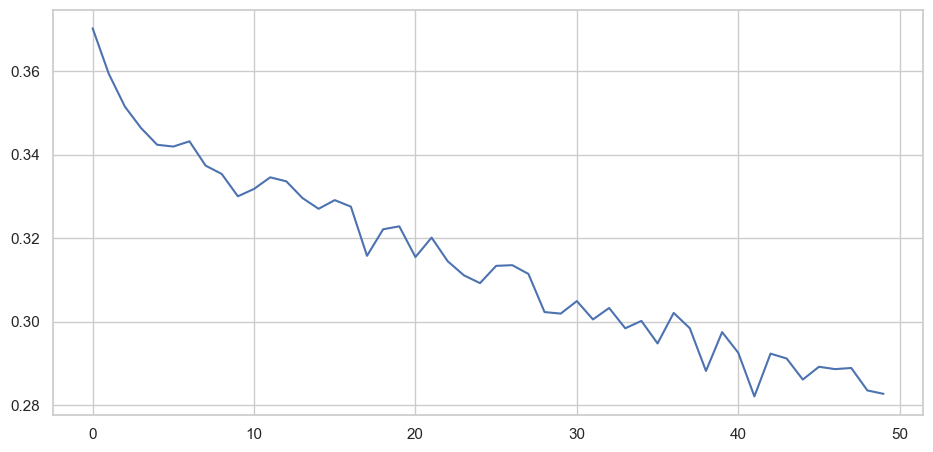

In [87]:
plt.figure(figsize=(10,11))
plt.subplot(2,1,1)
window_size = 5
plt.plot(History.history['loss'], label='Train loss')
plt.plot(History.history['val_loss'], label='Validation loss')

blurred_validation_loss = np.convolve(History.history['val_loss'], np.ones(window_size)/window_size, mode='valid')
plt.plot(np.arange(window_size//2, epochs-window_size//2), blurred_validation_loss,
          label='Validation Loss (Smoothed)', linewidth=30, color='orange', alpha=.2)
plt.legend()

plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.subplot(2,1,2)
plt.plot(History.history['accuracy'], label='Training Accuracy')
plt.plot(History.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend()
plt.show()


<a id="content5"></a>
## 5 ) Visualizing Predictons on the Validation Set

In [34]:
# getting predictions on val set.
pred=model.predict(x_test)
pred_digits=np.argmax(pred,axis=1)

34/34 [==============================] - 0s 10ms/step


In [35]:
# now storing some properly as well as misclassified indexes'.
i=0
prop_class=[]
mis_class=[]

for i in range(len(y_test)):
    if(np.argmax(y_test[i])==pred_digits[i]):
        prop_class.append(i)
    if(len(prop_class)==8):
        break

i=0
for i in range(len(y_test)):
    if(not np.argmax(y_test[i])==pred_digits[i]):
        mis_class.append(i)
    if(len(mis_class)==8):
        break

#### CORRECTLY CLASSIFIED FLOWER IMAGES

ValueError: y should be a 1d array, got an array of shape () instead.

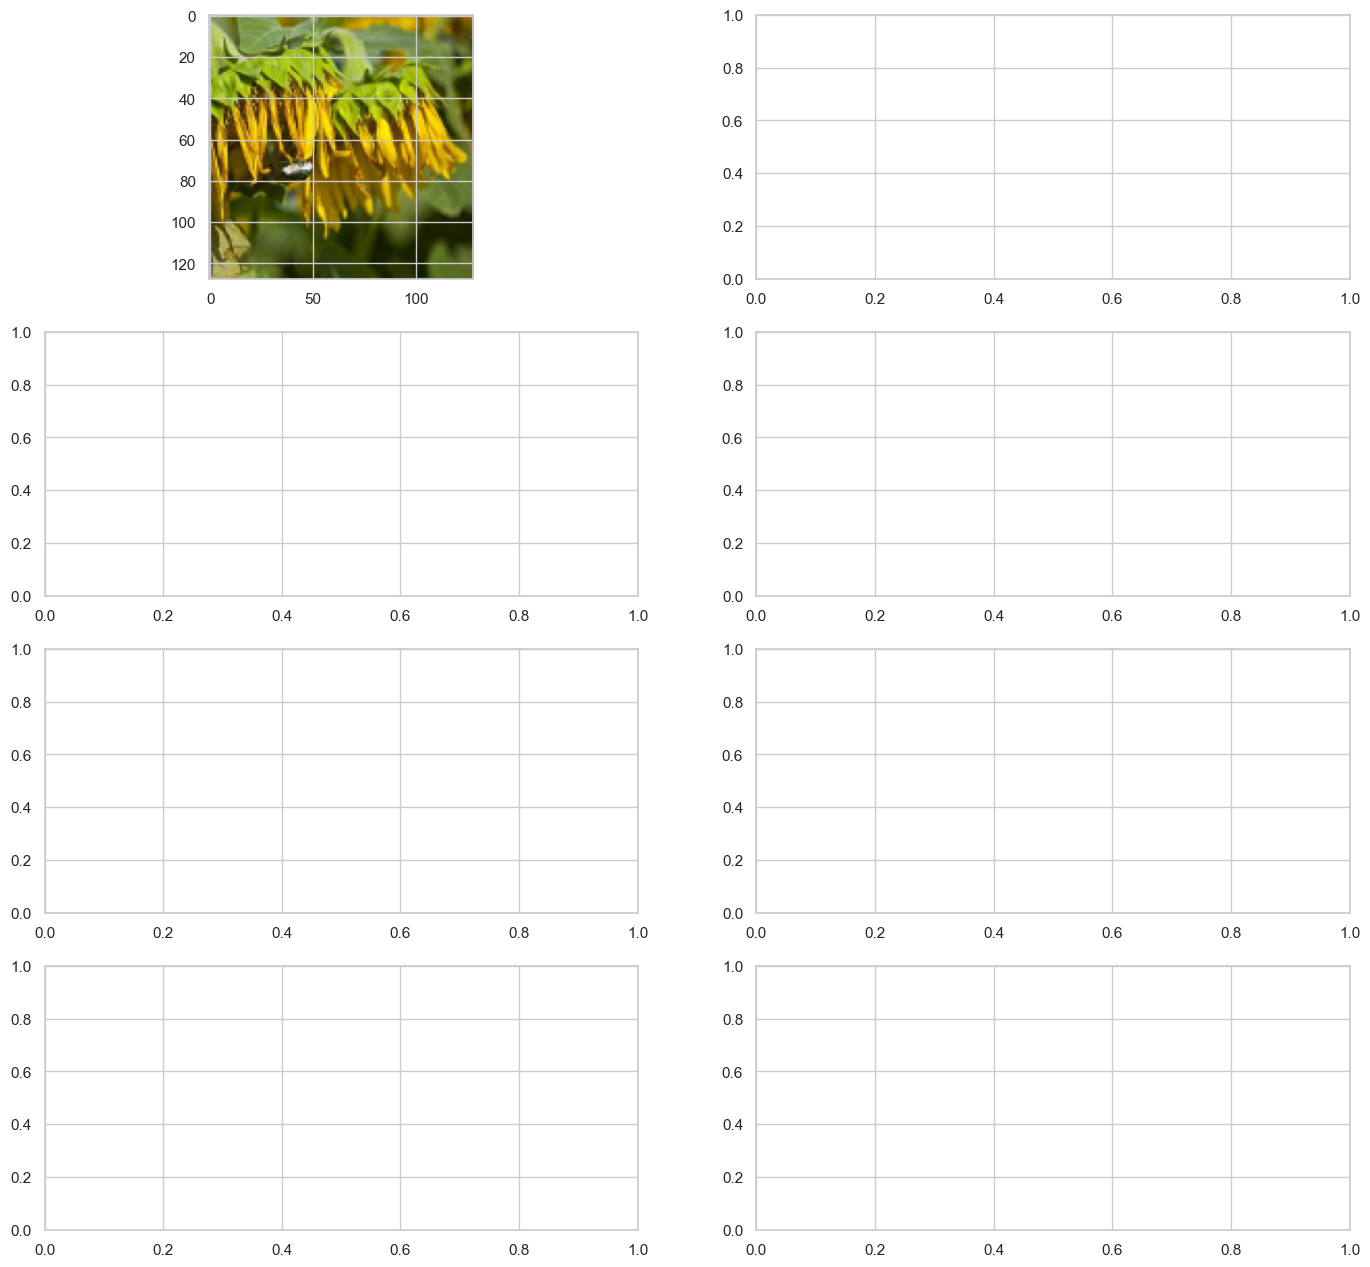

In [36]:
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

count=0
fig,ax=plt.subplots(4,2)
fig.set_size_inches(15,15)
for i in range (4):
    for j in range (2):
        ax[i,j].imshow(x_test[prop_class[count]])
        ax[i,j].set_title("Predicted Flower : "+str(le.inverse_transform([pred_digits[prop_class[count]]]))+"\n"+"Actual Flower : "+str(le.inverse_transform(np.argmax([y_test[prop_class[count]]]))))
        plt.tight_layout()
        count+=1

#### MISCLASSIFIED IMAGES OF FLOWERS

In [ ]:
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

count=0
fig,ax=plt.subplots(4,2)
fig.set_size_inches(15,15)
for i in range (4):
    for j in range (2):
        ax[i,j].imshow(x_test[mis_class[count]])
        ax[i,j].set_title("Predicted Flower : "+str(le.inverse_transform([pred_digits[mis_class[count]]]))+"\n"+"Actual Flower : "+str(le.inverse_transform(np.argmax([y_test[mis_class[count]]]))))
        plt.tight_layout()
        count+=1



<a id="content6"></a>
## 6 ) Using trained head of the classification network as a embading function


In [118]:
# Load the saved model
model = tf.keras.models.load_model('../models/CNN_model_1.h5')
model.summary()

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_46 (Conv2D)          (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d_46 (MaxPoolin  (None, 63, 63, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_47 (Conv2D)          (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_47 (MaxPoolin  (None, 30, 30, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_48 (Conv2D)          (None, 28, 28, 128)       73856     
                                                                 
 max_pooling2d_48 (MaxPoolin  (None, 14, 14, 128)    

In [120]:

# Create a new model that outputs the output of the Dense layer with 128 units
layer_name = 'dense_41'
intermediate_layer_model = tf.keras.Model(inputs=model.input,
                                 outputs=model.get_layer(layer_name).output)

intermediate_layer_model.predict(X).shape

135/135 [==============================] - 1s 7ms/step


(4317, 128)

In [105]:
model = tf.saved_model.load('../models/CNN_model_2')
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

AttributeError: '_UserObject' object has no attribute 'compile'